In [552]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['figure.figsize'] = (20, 5)
mpl.rcParams['axes.grid'] = False
plt.style.use('ggplot')

In [553]:
# creating a dataframe from the csv file
df = pd.DataFrame(pd.read_csv('../CSI_Preprocessing/output/zero4_outputs.csv'))
df = df.drop([df.columns[0]], axis='columns') 
df = df.iloc[:,:-3]
df.reset_index(drop=True, inplace=True)
  
# Change UTC Time to CST Time 
from datetime import datetime

CST_time_list = []
for time in df['Time'].to_list():
    CST_time_list.append(datetime.fromtimestamp(time))

df['Time'] = pd.DataFrame(CST_time_list)

# Date Time: Minutes Seconds
# df.index = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S')
date_time = df['Time'].dt.strftime('%M %S')

# checking our dataframe once again
df.head()

,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58,Subcar_59,Subcar_60,Subcar_61
0,2022-01-08 08:35:41.784772,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079,402.951610,372.625818,343.914233
1,2022-01-08 08:35:42.807257,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,367.766230,339.484904,339.087009,343.083080,343.739727,346.943799,351.039884,350.000000,353.509547,361.763735
2,2022-01-08 08:35:43.831145,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791,315.483756,278.195974,245.790561
3,2022-01-08 08:35:44.854967,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,459.243944,413.706418,406.503383,392.998728,389.802514,381.072172,390.508643,384.002604,387.497097,393.782935
4,2022-01-08 08:35:45.880211,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355,670.391677,646.208945,616.507096


<AxesSubplot:>

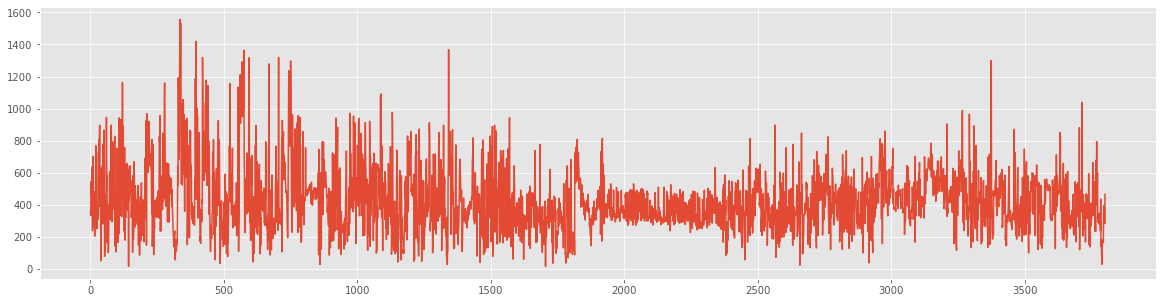

In [554]:
temp = df['Subcar_7']
temp.plot()

In [555]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + 5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [556]:
WINDOW_SIZE = 144
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((3658, 5, 1), (3658,))

In [557]:
x_train, y_train = X[:2000], y[:2000]
x_test, y_test = X[700:750], y[700:750]
x_val, y_val = X[750:], y[750:]
print('x_train set:', x_train.shape)
print('y_train set:', y_train.shape)
print('x_test set:', x_test.shape)
print('y_test:', y_test.shape)
print('x_val set:', x_val.shape)
print('y_val set:', y_val.shape)

x_train set: (2000, 5, 1)
y_train set: (2000,)
x_test set: (50, 5, 1)
y_test: (50,)
x_val set: (2908, 5, 1)
y_val set: (2908,)


In [558]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [559]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(Conv1D(64, kernel_size=2))
model1.add(Conv1D(32, kernel_size= 2))
model1.add(Flatten())
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 4, 64)             192       
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 3, 32)             4128      
_________________________________________________________________
flatten_26 (Flatten)         (None, 96)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 8)                 776       
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 9         
Total params: 5,105
Trainable params: 5,105
Non-trainable params: 0
_________________________________________________________________


In [560]:
cp = ModelCheckpoint('../save/model1/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

In [561]:
model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[early_stopping,cp])

Epoch 1/100
63/63 [==============================] - 1s 11ms/step - loss: 103668.7578 - mean_absolute_error: 256.1653 - val_loss: 35297.2617 - val_mean_absolute_error: 144.6568
Epoch 2/100
63/63 [==============================] - 1s 9ms/step - loss: 47097.5391 - mean_absolute_error: 158.7705 - val_loss: 25994.5273 - val_mean_absolute_error: 116.3063
Epoch 3/100
63/63 [==============================] - 1s 10ms/step - loss: 44281.2070 - mean_absolute_error: 152.8665 - val_loss: 25184.9473 - val_mean_absolute_error: 114.4753
Epoch 4/100
63/63 [==============================] - 1s 10ms/step - loss: 42832.2344 - mean_absolute_error: 150.0559 - val_loss: 24629.5000 - val_mean_absolute_error: 113.1240
Epoch 5/100
63/63 [==============================] - 1s 10ms/step - loss: 41828.9609 - mean_absolute_error: 148.0956 - val_loss: 24214.5137 - val_mean_absolute_error: 112.0340
Epoch 6/100
63/63 [==============================] - 1s 10ms/step - loss: 41095.9883 - mean_absolute_error: 146.4065 - v

In [562]:
from tensorflow.keras.models import load_model
model1 = load_model('../save/model1/')

In [563]:
train_predictions1 = model1.predict(x_train).flatten()
train_results1 = pd.DataFrame(data={'Train Predictions': train_predictions1, 'Actuals': y_train})
train_results1

,Train Predictions,Actuals
0,425.628326,587.749096
1,481.170227,635.824661
2,530.492249,360.188839
3,471.125732,237.118114
4,365.207764,507.607132
...,...,...
1995,321.081055,321.810503
1996,313.752991,366.890992
1997,323.033539,323.975308
1998,319.165100,329.789327


Text(0, 0.5, 'Amplitude')

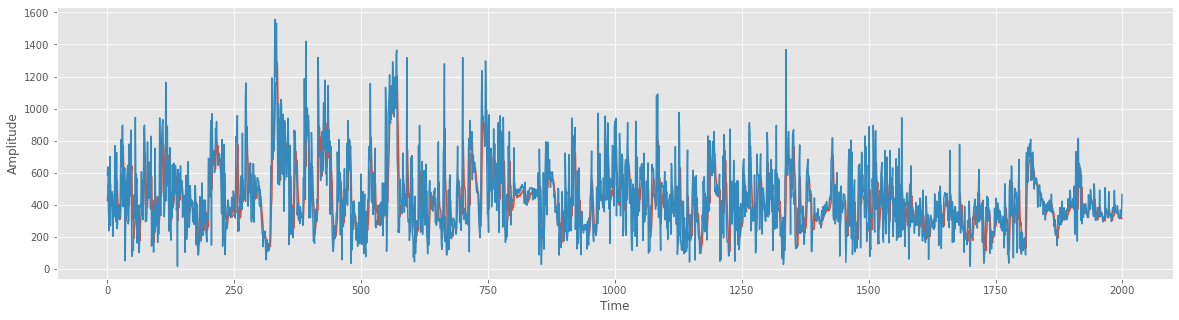

In [564]:
plt.plot(train_results1['Train Predictions'])
plt.plot(train_results1['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

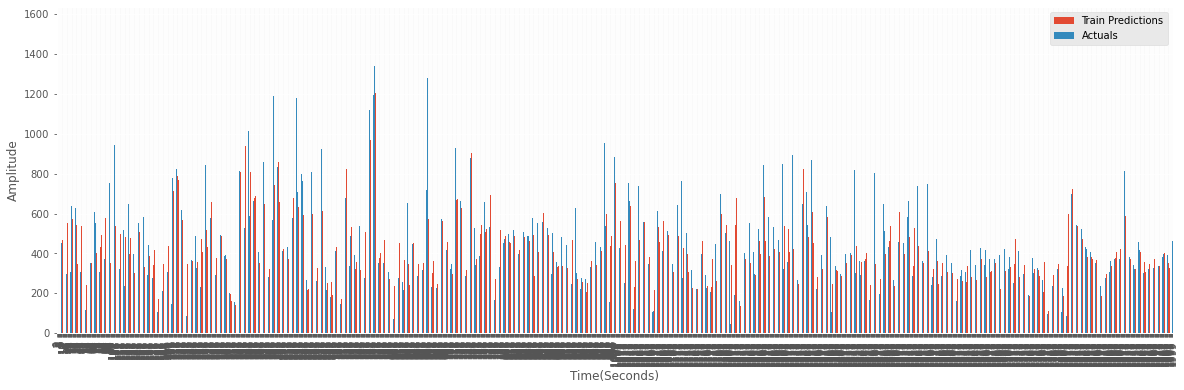

In [565]:
fig,ax = plt.subplots(figsize=(20,6))
train_results1.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

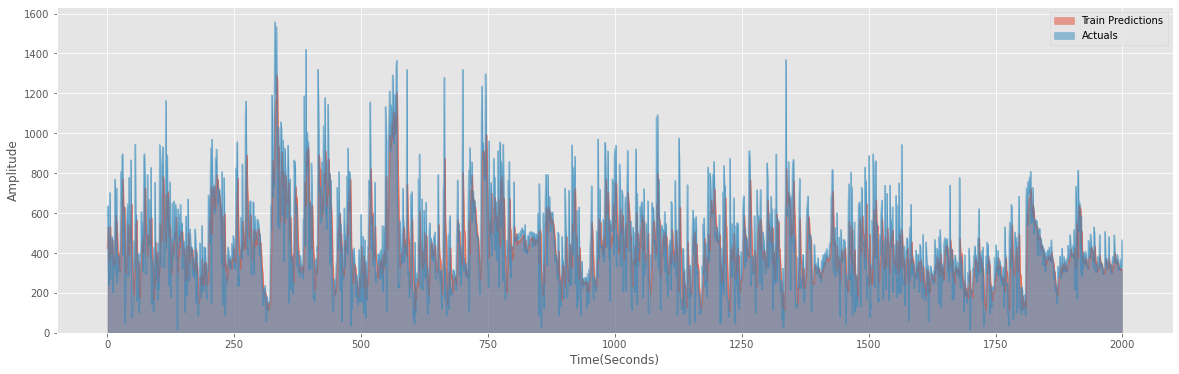

In [566]:
fig,ax = plt.subplots(figsize=(20,6))
train_results1.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

In [567]:
val_predictions1 = model1.predict(x_val).flatten()
val_results1 = pd.DataFrame(data={'Val predictions': val_predictions1, 'Actuals': y_val})
val_results1

,Val predictions,Actuals
0,646.449097,340.834271
1,513.955505,228.319951
2,373.176758,961.095729
3,559.276184,484.530701
4,506.122162,535.452145
...,...,...
2903,306.988586,381.808853
2904,354.072449,278.167216
2905,334.339905,195.205020
2906,269.946930,607.356567


Text(0, 0.5, 'Amplitude')

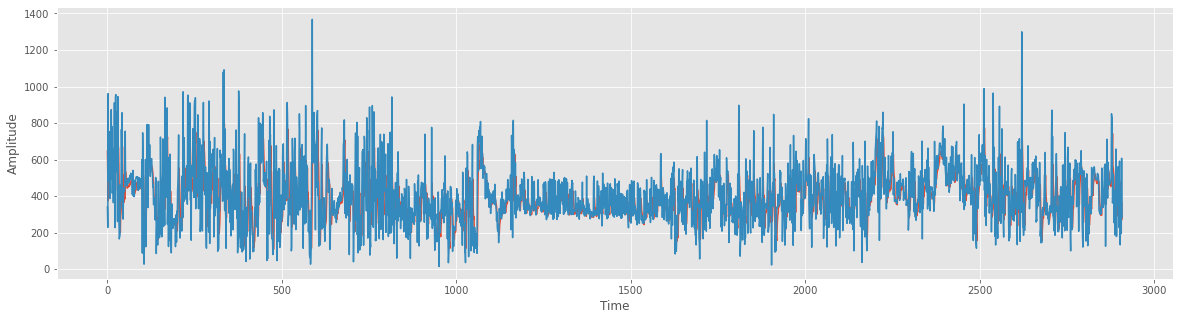

In [568]:
plt.plot(val_results1['Val predictions'])
plt.plot(val_results1['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

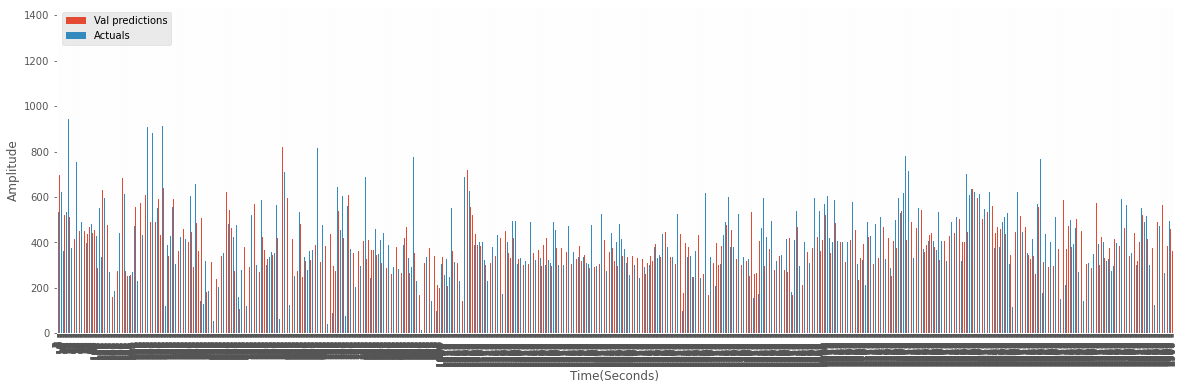

In [569]:
fig,ax = plt.subplots(figsize=(20,6))
val_results1.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

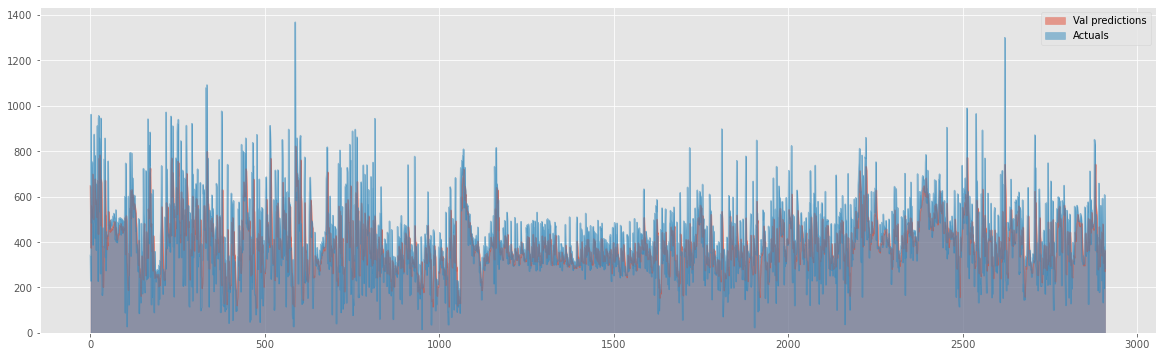

In [570]:
fig,ax = plt.subplots(figsize=(20,6))
val_results1.plot(kind='area',ax=ax,stacked=False)
plt.show()

In [571]:
test_predictions1 = model1.predict(x_test).flatten()
test_results1 = pd.DataFrame(data={'Test predictions': test_predictions1, 'Actuals': y_test})
test_results1

,Test predictions,Actuals
0,458.245667,1318.891959
1,801.674316,427.907700
2,647.088684,308.974109
3,518.629883,375.431751
4,510.293243,315.995253
5,486.387207,323.487249
6,329.976746,281.128085
7,293.401581,346.161812
8,315.675232,294.266886
9,296.216583,291.756748


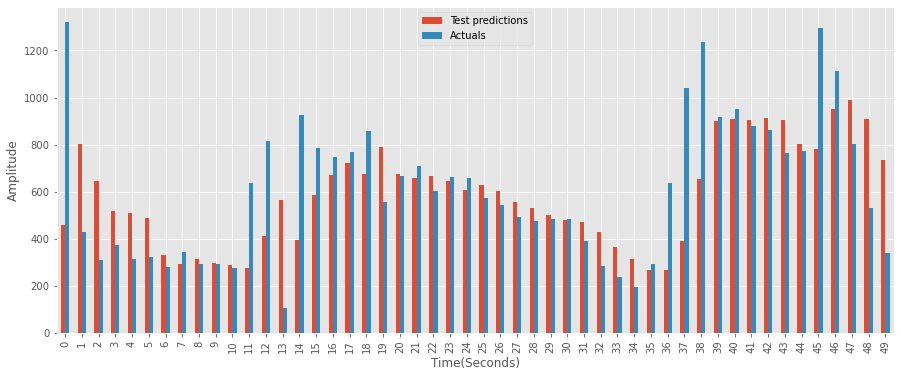

In [572]:
fig,ax = plt.subplots(figsize=(15,6))
test_results1.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

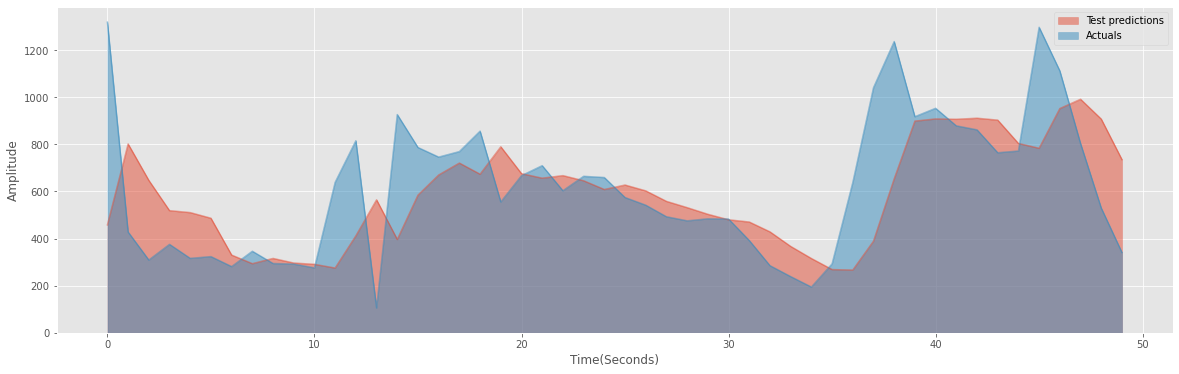

In [573]:
fig,ax = plt.subplots(figsize=(20,6))
test_results1.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

Text(0, 0.5, 'Amplitude')

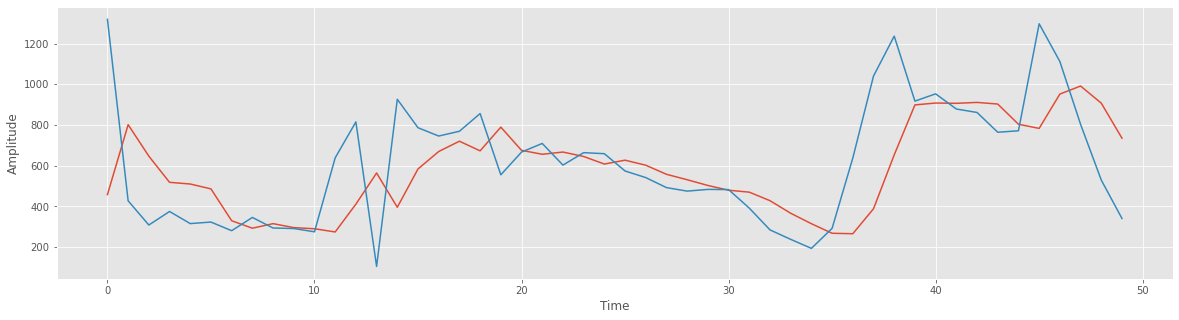

In [574]:
plt.plot(test_results1['Test predictions'])
plt.plot(test_results1['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

In [575]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Conv1D(32, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(32, 'relu'))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 4, 64)             192       
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 3, 32)             4128      
_________________________________________________________________
flatten_27 (Flatten)         (None, 96)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 32)                3104      
_________________________________________________________________
dense_81 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 9         
Total params: 7,697
Trainable params: 7,697
Non-trainable params: 0
___________________________________________________

In [576]:
cp2 = ModelCheckpoint('../save/model2/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

In [577]:
model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, callbacks=[early_stopping,cp2])

Epoch 1/50
63/63 [==============================] - 1s 12ms/step - loss: 161225.2188 - mean_absolute_error: 331.2596 - val_loss: 51204.2969 - val_mean_absolute_error: 182.4693
Epoch 2/50
63/63 [==============================] - 1s 11ms/step - loss: 54462.2188 - mean_absolute_error: 172.2559 - val_loss: 27012.4766 - val_mean_absolute_error: 118.6605
Epoch 3/50
63/63 [==============================] - 1s 11ms/step - loss: 46217.0078 - mean_absolute_error: 155.6543 - val_loss: 25994.8730 - val_mean_absolute_error: 115.8903
Epoch 4/50
63/63 [==============================] - 1s 11ms/step - loss: 44415.0625 - mean_absolute_error: 152.1736 - val_loss: 25664.6406 - val_mean_absolute_error: 115.3514
Epoch 5/50
63/63 [==============================] - 1s 11ms/step - loss: 43101.8789 - mean_absolute_error: 149.6414 - val_loss: 24776.7891 - val_mean_absolute_error: 112.8537
Epoch 6/50
63/63 [==============================] - 1s 11ms/step - loss: 42092.5000 - mean_absolute_error: 147.6776 - val_lo

In [578]:
from tensorflow.keras.models import load_model
model2 = load_model('../save/model2/')

In [579]:
train_predictions2 = model2.predict(x_train).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions': train_predictions2, 'Actuals': y_train})
train_results2

,Train Predictions,Actuals
0,434.151459,587.749096
1,495.423492,635.824661
2,553.116089,360.188839
3,461.274628,237.118114
4,353.588928,507.607132
...,...,...
1995,322.107880,321.810503
1996,317.367126,366.890992
1997,332.668427,323.975308
1998,323.522644,329.789327


Text(0, 0.5, 'Amplitude')

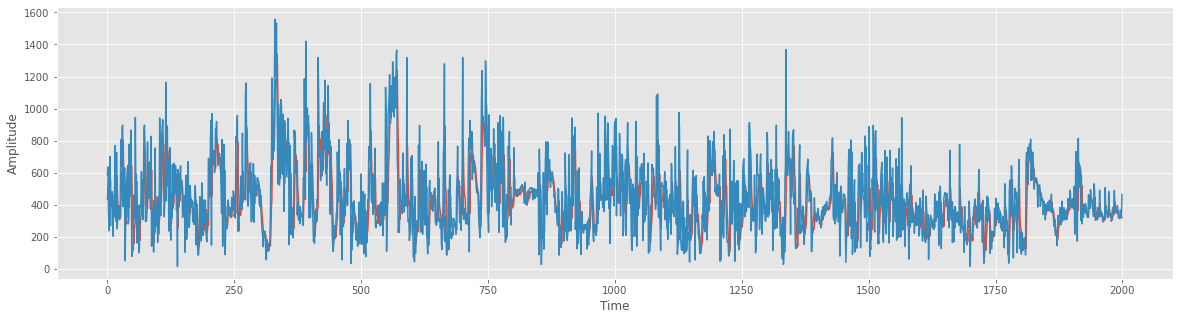

In [580]:
plt.plot(train_results2['Train Predictions'])
plt.plot(train_results2['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

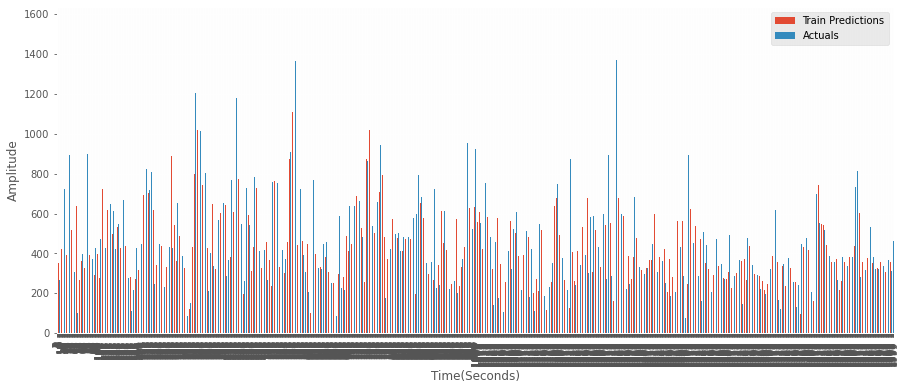

In [581]:
fig,ax = plt.subplots(figsize=(15,6))
train_results2.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

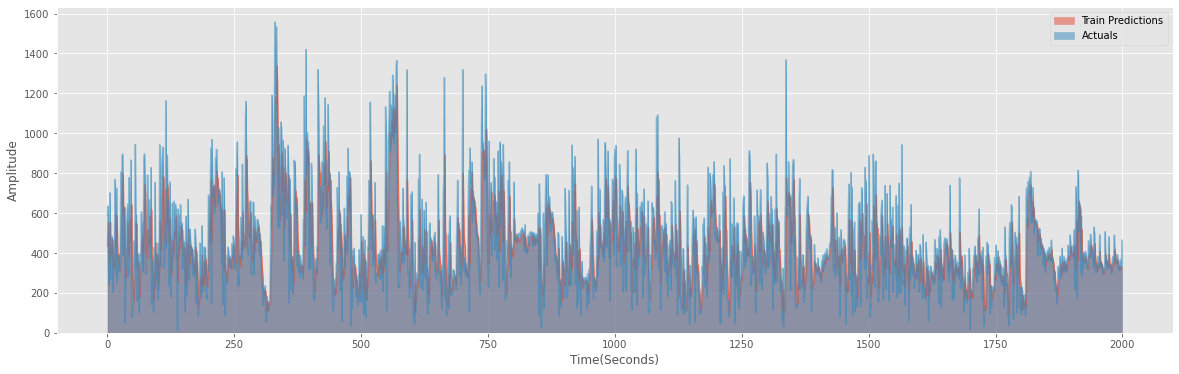

In [582]:
fig,ax = plt.subplots(figsize=(20,6))
train_results2.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

In [583]:
val_predictions2 = model2.predict(x_val).flatten()
val_results2 = pd.DataFrame(data={'Val predictions': val_predictions2, 'Actuals': y_val})
val_results2

,Val predictions,Actuals
0,593.673523,340.834271
1,477.146515,228.319951
2,347.627930,961.095729
3,589.434326,484.530701
4,502.378296,535.452145
...,...,...
2903,290.372986,381.808853
2904,358.952118,278.167216
2905,321.999390,195.205020
2906,259.414917,607.356567


Text(0, 0.5, 'Amplitude')

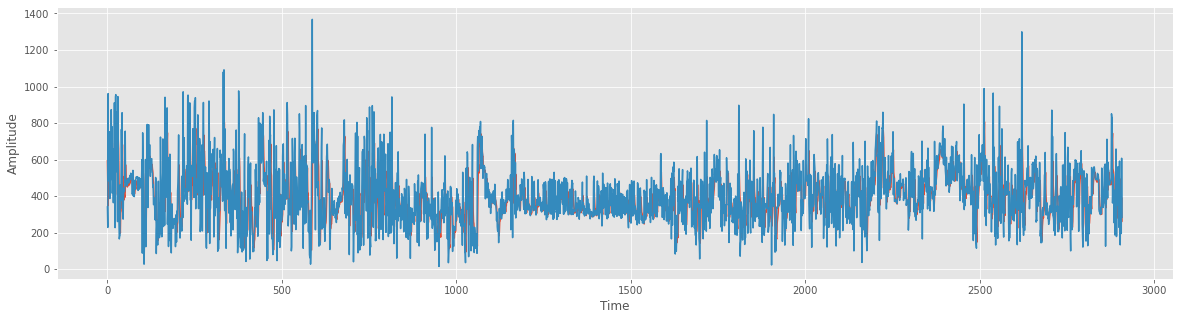

In [584]:
plt.plot(val_results2['Val predictions'])
plt.plot(val_results2['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

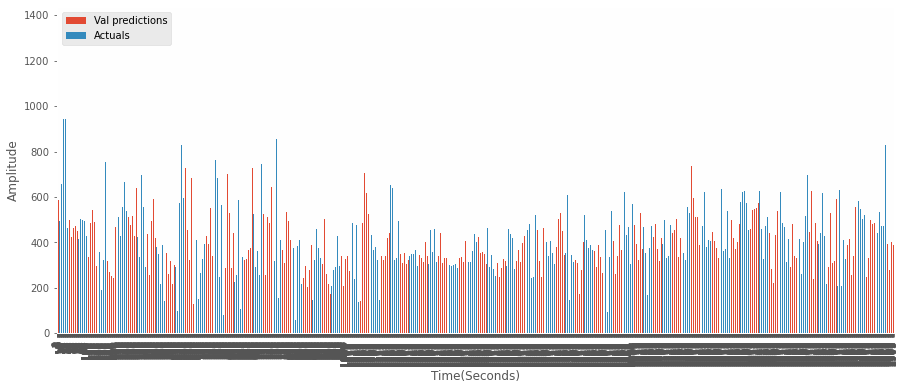

In [585]:
fig,ax = plt.subplots(figsize=(15,6))
val_results2.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

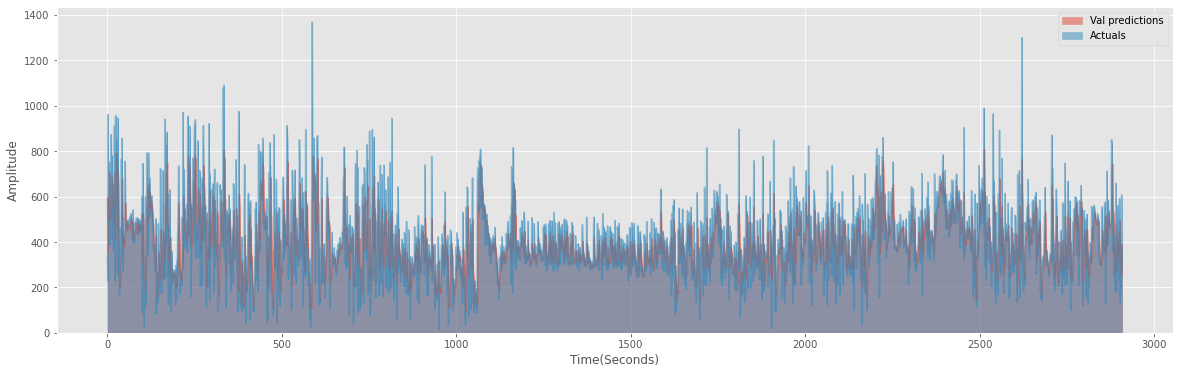

In [586]:
fig,ax = plt.subplots(figsize=(20,6))
val_results2.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

In [587]:
test_predictions2 = model2.predict(x_test).flatten()
test_results2 = pd.DataFrame(data={'Test predictions': test_predictions2, 'Actuals': y_test})
test_results2

,Test predictions,Actuals
0,487.636200,1318.891959
1,799.195618,427.907700
2,592.838379,308.974109
3,483.991577,375.431751
4,448.906128,315.995253
5,439.069427,323.487249
6,330.867432,281.128085
7,294.813629,346.161812
8,321.940735,294.266886
9,299.187195,291.756748


Text(0, 0.5, 'Amplitude')

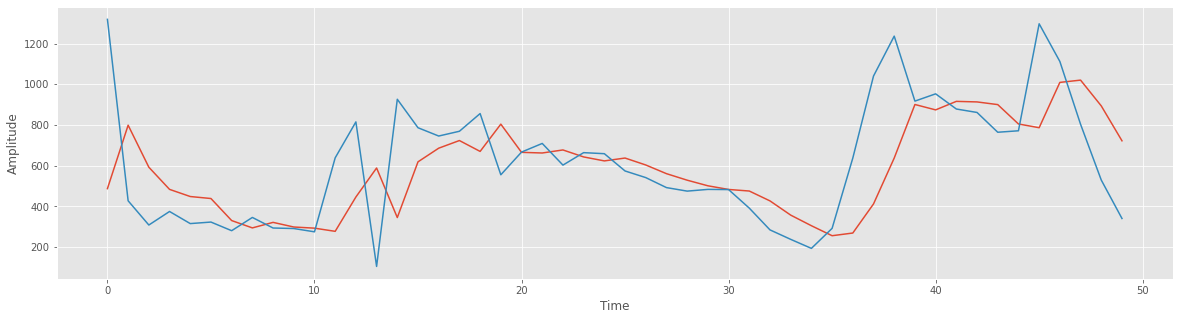

In [588]:
plt.plot(test_results2['Test predictions'])
plt.plot(test_results2['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

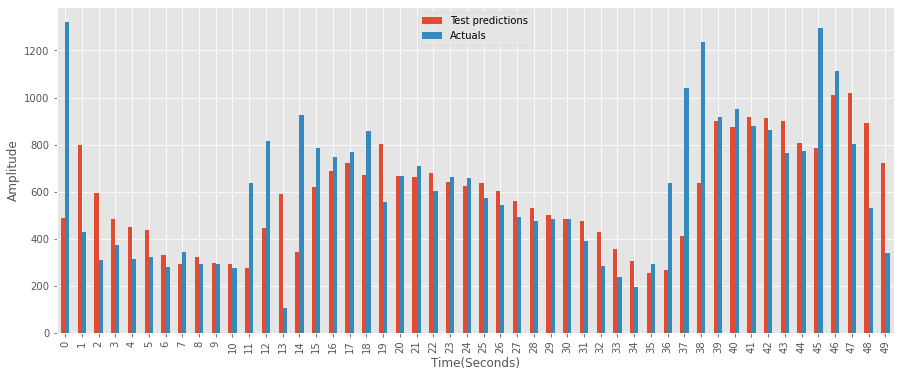

In [589]:
fig,ax = plt.subplots(figsize=(15,6))
test_results2.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

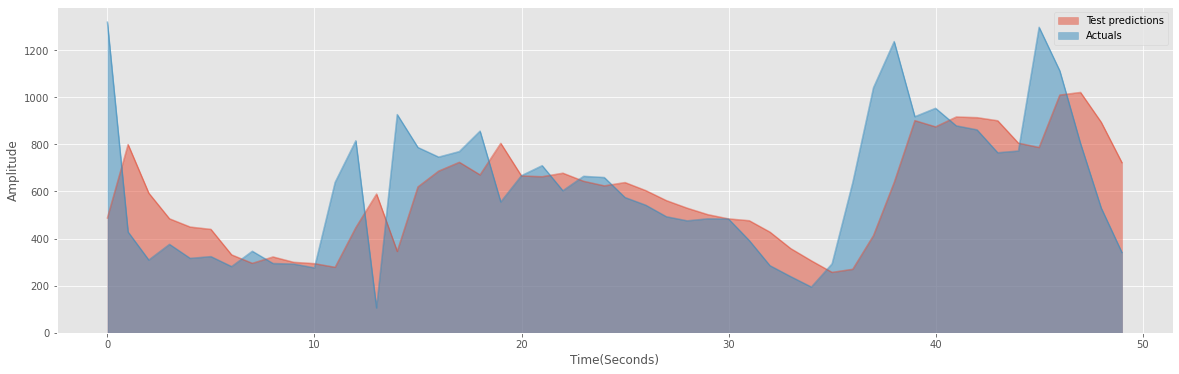

In [590]:
fig,ax = plt.subplots(figsize=(20,6))
test_results2.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

In [591]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(Conv1D(64, kernel_size=2))
model3.add(Flatten())
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()


Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_39 (Conv1D)           (None, 4, 64)             192       
_________________________________________________________________
flatten_28 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 9         
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [592]:
cp3 = ModelCheckpoint('../save/model3/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

In [593]:
model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, callbacks=[early_stopping,cp3])

Epoch 1/50
63/63 [==============================] - 1s 9ms/step - loss: 278821.2188 - mean_absolute_error: 465.8164 - val_loss: 119812.5547 - val_mean_absolute_error: 309.3471
Epoch 2/50
63/63 [==============================] - 1s 8ms/step - loss: 107500.8984 - mean_absolute_error: 262.0287 - val_loss: 48971.0703 - val_mean_absolute_error: 178.7744
Epoch 3/50
63/63 [==============================] - 1s 8ms/step - loss: 59837.3945 - mean_absolute_error: 183.3706 - val_loss: 31164.0254 - val_mean_absolute_error: 131.4873
Epoch 4/50
63/63 [==============================] - 1s 8ms/step - loss: 49161.4609 - mean_absolute_error: 161.6596 - val_loss: 27551.8438 - val_mean_absolute_error: 120.5047
Epoch 5/50
63/63 [==============================] - 0s 8ms/step - loss: 46789.6797 - mean_absolute_error: 156.4432 - val_loss: 26536.8906 - val_mean_absolute_error: 117.7637
Epoch 6/50
63/63 [==============================] - 0s 8ms/step - loss: 45791.4844 - mean_absolute_error: 154.8308 - val_loss: 

In [594]:
train_predictions3 = model3.predict(x_train).flatten()
train_results3 = pd.DataFrame(data={'Train Predictions': train_predictions3, 'Actuals': y_train})
train_results3

,Train Predictions,Actuals
0,425.849884,587.749096
1,485.187347,635.824661
2,539.458435,360.188839
3,459.846191,237.118114
4,355.124420,507.607132
...,...,...
1995,318.037628,321.810503
1996,313.106354,366.890992
1997,326.231171,323.975308
1998,318.523438,329.789327


Text(0, 0.5, 'Amplitude')

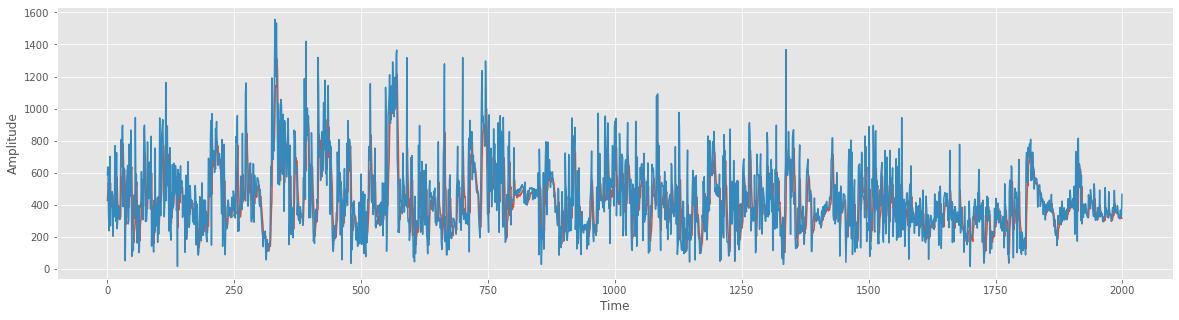

In [595]:
plt.plot(train_results3['Train Predictions'])
plt.plot(train_results3['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

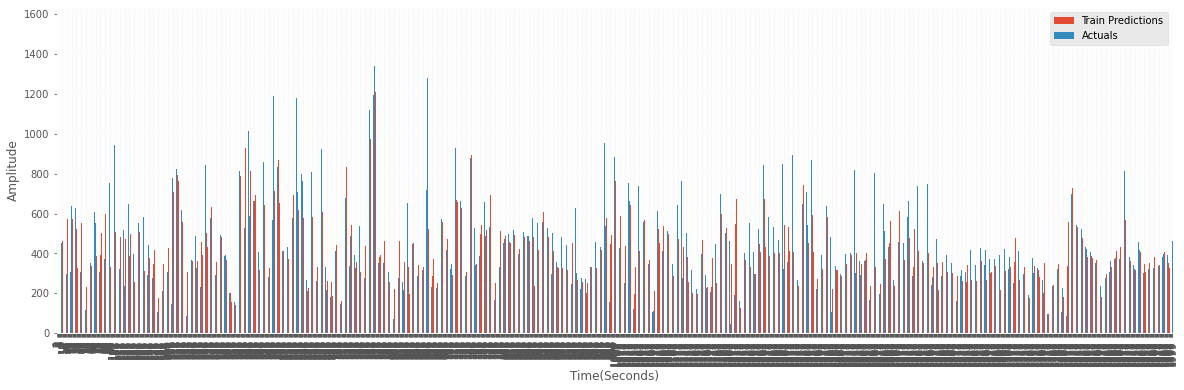

In [596]:
fig,ax = plt.subplots(figsize=(20,6))
train_results3.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

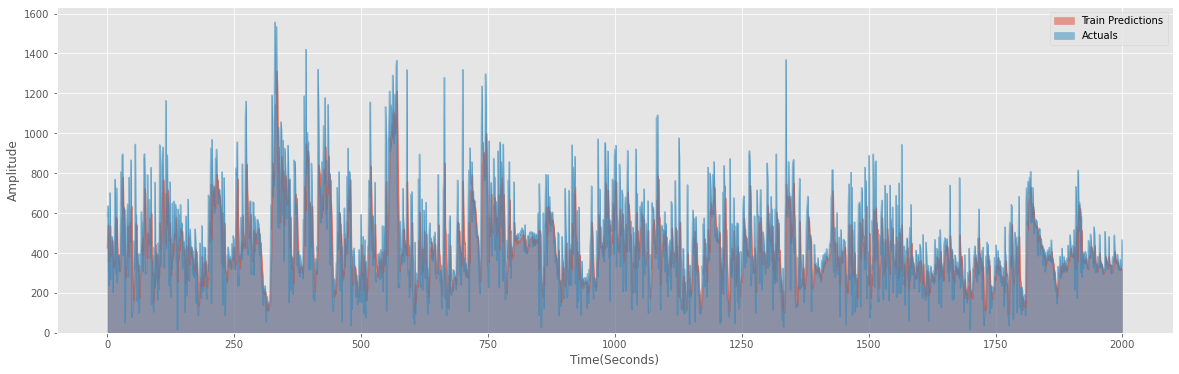

In [597]:
fig,ax = plt.subplots(figsize=(20,6))
train_results3.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

In [598]:
val_predictions3 = model3.predict(x_val).flatten()
val_results3 = pd.DataFrame(data={'Val predictions': val_predictions3, 'Actuals': y_val})
val_results3

,Val predictions,Actuals
0,598.746948,340.834271
1,480.633789,228.319951
2,349.667572,961.095729
3,578.662964,484.530701
4,483.826324,535.452145
...,...,...
2903,291.878693,381.808853
2904,355.273712,278.167216
2905,319.395233,195.205020
2906,260.701813,607.356567


Text(0, 0.5, 'Amplitude')

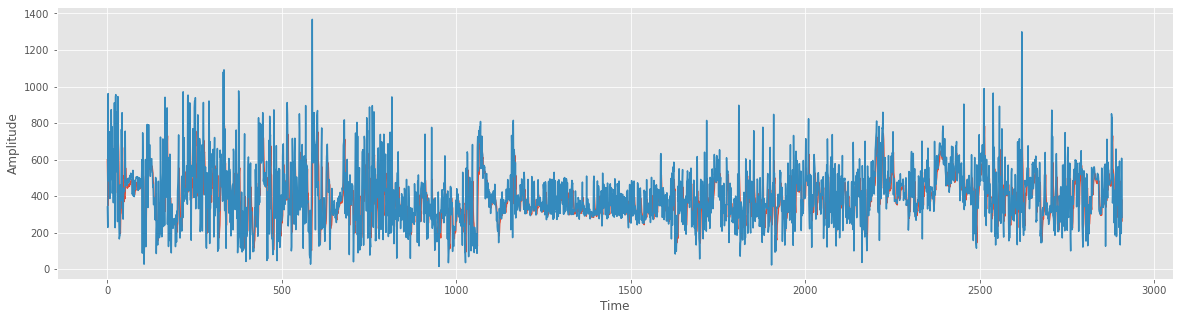

In [599]:
plt.plot(val_results3['Val predictions'])
plt.plot(val_results3['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

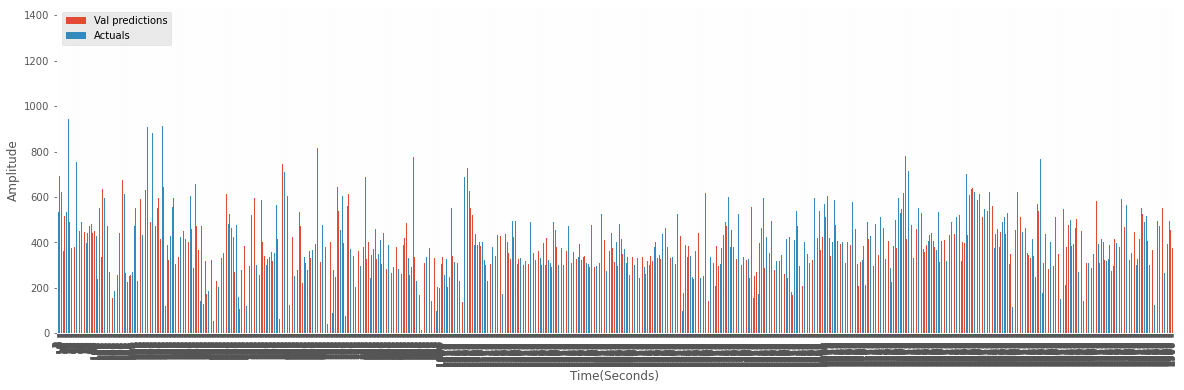

In [600]:
fig,ax = plt.subplots(figsize=(20,6))
val_results3.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

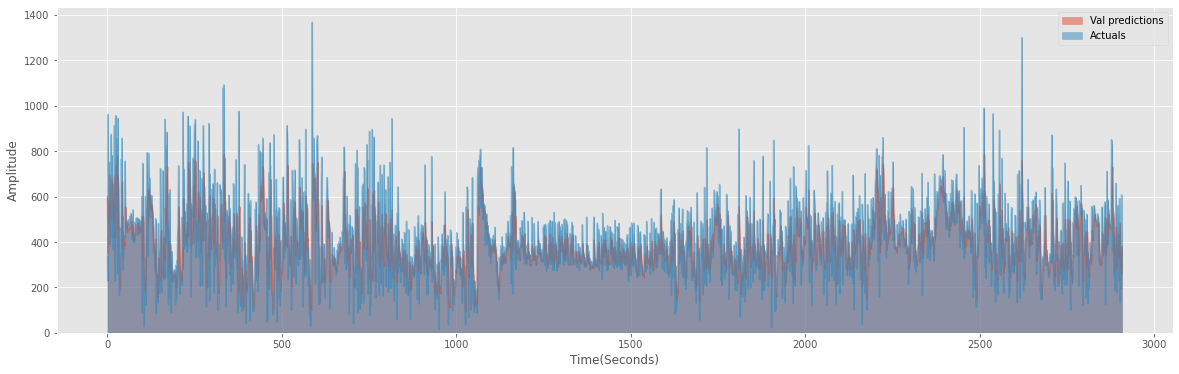

In [601]:
fig,ax = plt.subplots(figsize=(20,6))
val_results3.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

In [602]:
test_predictions3 = model3.predict(x_test).flatten()
test_results3 = pd.DataFrame(data={'Test predictions': test_predictions3, 'Actuals': y_test})
test_results3

,Test predictions,Actuals
0,471.009094,1318.891959
1,760.994690,427.907700
2,589.861023,308.974109
3,491.742645,375.431751
4,445.272675,315.995253
5,450.445709,323.487249
6,327.579010,281.128085
7,291.447662,346.161812
8,316.852936,294.266886
9,294.519379,291.756748


Text(0, 0.5, 'Amplitude')

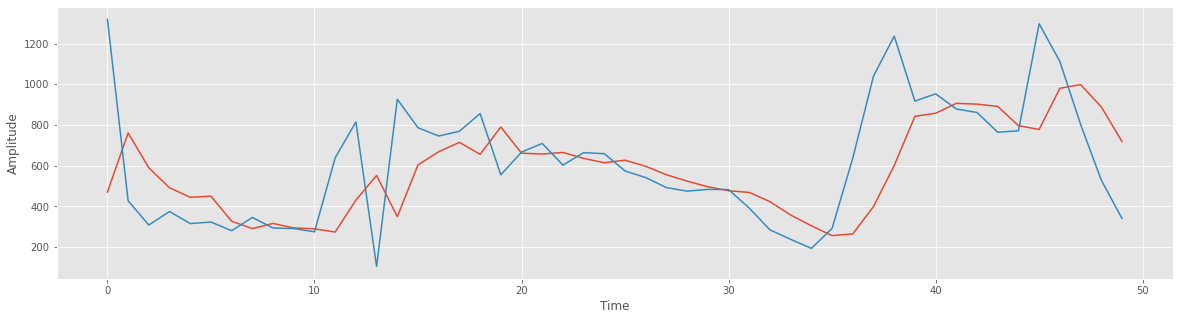

In [603]:
plt.plot(test_results3['Test predictions'])
plt.plot(test_results3['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

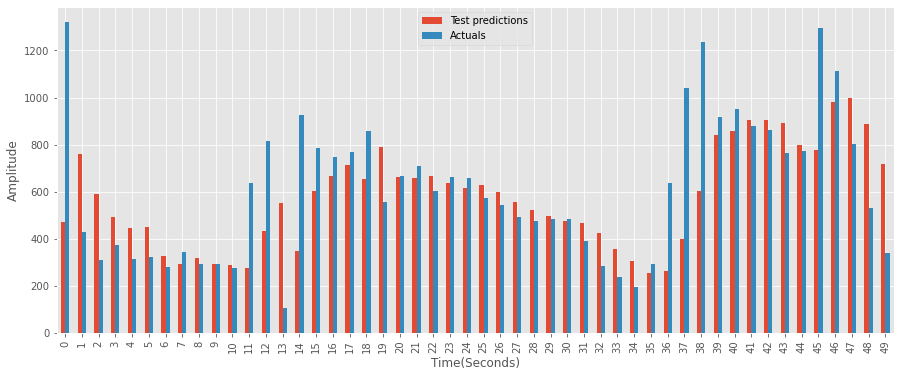

In [604]:
fig,ax = plt.subplots(figsize=(15,6))
test_results3.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

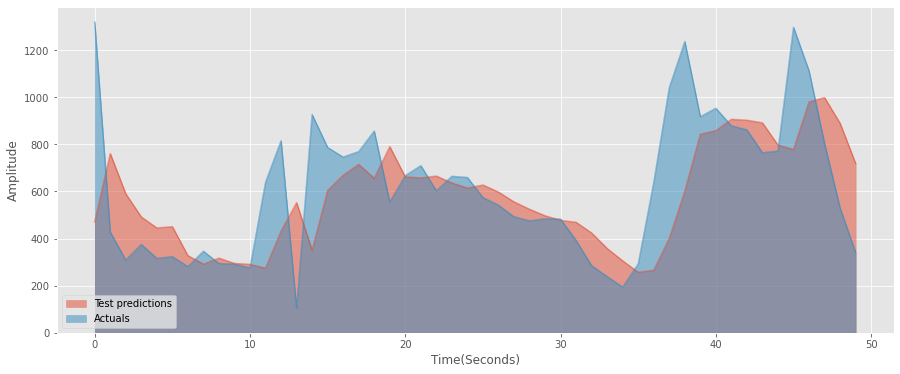

In [605]:
fig,ax = plt.subplots(figsize=(15,6))
test_results3.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()